In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons
!pip install pyyaml h5py
!pip install toolz scikit-allel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.5 MB/s eta 0:00:00


In [3]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.12.0


## Setup

In [4]:
import os
# os.environ["MODIN_CPUS"] = "8"
# from distributed import Client
# client = Client()
import numpy as np
import math
import re
import itertools
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet as efn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.constraints import Constraint
# import allel
from scipy.spatial.distance import squareform
%matplotlib inline
from toolz import interleave
from tqdm import tqdm
import allel
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold,StratifiedKFold

print("Tensorflow version " + tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow version 2.12.0


## Hardware Config

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = strategy.num_replicas_in_sync
# Number of computing cores, is 8 for a TPU V3-8
print(f'N_REPLICAS: {N_REPLICAS}')

Running on TPU  grpc://10.44.229.66:8470


N_REPLICAS: 8


## Prepare the data

In [6]:
root_dir = '[data_dir]/'
new_data_header = ""
# get header
with open(root_dir + "DELL.chr22.genotypes.full.vcf", 'r') as f_in:
    # skip info
    for line_num in range(70):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + "DELL.chr22.genotypes.full.vcf", comment='#', sep='\t', names=new_data_header.strip().split('\t'), header=None)
info = genotypes.iloc[:, :9]
genotypes = genotypes.iloc[:, 9:].T
headers = genotypes.columns[:]
genotypes

,0,1,2,3,4,5,6,7,8,9,...,563,564,565,566,567,568,569,570,571,572
HG00096,0|0,0|0,0|0,0|0,0|0,0|0,1|1,0|0,0|0,0|0,...,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00097,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00099,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00100,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21141,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21142,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21143,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|1,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [7]:
ped_file = '[data_dir]/integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')

In [8]:
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [9]:
Y_train = pedigree.loc[genotypes.index]['Population']
Y_train.shape

(2504,)

In [10]:
X = genotypes[genotypes.index.isin(Y_train.index)]
X.shape

(2504, 573)

In [11]:
X = X.replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
})
X.shape

(2504, 573)

### MAF


In [12]:
def get_max_genotype(g):
  v1, v2 = g.split("|")
  return max(int(v1), int(v2)) + 1

def key_gen(v1, v2):
  return f"{v1}|{v2}"

In [13]:
def maf_mapper(txt):
  af = min(list(map(lambda x: float(x), txt.split(";")[1].split("=")[1].split(","))))
  return min(af, 1-af)

In [14]:
mafs = info.iloc[:, 7:8].applymap(maf_mapper)
mafs

,INFO
0,0.024960
1,0.005791
2,0.037141
3,0.000399
4,0.000399
...,...
568,0.000599
569,0.023562
570,0.000200
571,0.000200


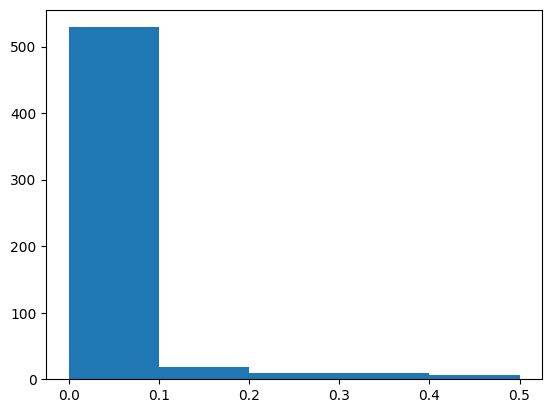

In [15]:
plt.hist(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5]);

In [16]:
bin_labels = np.digitize(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5], right=False)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5]), array([529,  18,  10,  10,   6]))

In [17]:
# hyperparameters
feature_size = X.shape[1]
inChannel = 3
learning_rate = 0.004
weight_decay = 0.00001
embed_dim = 64  # Embedding size for each token
num_heads = 8 # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
regularization_coef_l1 = 1e-4
dropout_rate = 0.25
attention_range = 0
chunk_size = X.shape[1]

## Convert to tensorflow dataset

In [18]:
@tf.function()
def add_attention_mask(X_sample, y_sample):
  depth = 3
  mask_size = tf.cast(X_sample.shape[0]*0.5, dtype=tf.int64)
  mask_idx = tf.reshape(tf.random.shuffle(tf.range(X_sample.shape[0]))[:mask_size], (-1, 1))
  updates = tf.math.add(tf.ones(shape=(mask_idx.shape[0]), dtype=tf.int64), 1)
  X_masked = tf.tensor_scatter_nd_update(X_sample, mask_idx, updates)
  return tf.one_hot(X_masked, depth), tf.one_hot(y_sample, depth-1)

In [19]:
def map_values_1(x):
  return 0 if (x == 0 or x == 1) else 1

def map_values_2(x):
  return 0 if (x == 0 or x == 2) else 1

def get_dataset(x, chunk_start, chunk_end, start_offset, end_offset, batch_size, training=True):
  AUTO = tf.data.AUTOTUNE

  _x = np.empty((x.shape[0] * 2, chunk_end-chunk_start), dtype=x.dtype)

  map_values_1_vec = np.vectorize(map_values_1)
  map_values_2_vec = np.vectorize(map_values_2)

  _x[0::2] = map_values_1_vec(x[:, chunk_start:chunk_end])
  _x[1::2] = map_values_2_vec(x[:, chunk_start:chunk_end])
  new_chunk_end = _x.shape[1]

  dataset = tf.data.Dataset.from_tensor_slices((_x,
                                                _x[:, start_offset:new_chunk_end-end_offset]))

  if training:
    dataset = dataset.shuffle(_x.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.repeat()

  # Add Attention Mask
  dataset = dataset.map(add_attention_mask, num_parallel_calls=AUTO, deterministic=False)

  # Prefetech to not map the whole dataset
  dataset = dataset.prefetch(AUTO)

  dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)

  return dataset

## Custom Layers

In [20]:
class CrossAttentionLayer(layers.Layer):
  def __init__(self, local_dim, global_dim,
               start_offset=0, end_offset=0,
               activation=tf.nn.gelu, dropout_rate=0.1,
               n_heads=num_heads):
    super(CrossAttentionLayer, self).__init__()
    self.local_dim = local_dim
    self.global_dim = global_dim
    self.dropout_rate = dropout_rate
    self.activation = activation
    self.start_offset = start_offset
    self.end_offset = end_offset
    self.num_heads = n_heads
    self.layer_norm00 = layers.LayerNormalization()
    self.layer_norm01 = layers.LayerNormalization()
    self.layer_norm1 = layers.LayerNormalization()
    self.ffn = tf.keras.Sequential(
          [
            layers.Dense(self.local_dim//2, activation=self.activation,
                        ),
            layers.Dense(self.local_dim,
                        activation=self.activation,
                        ), ]
      )
    self.add0 = layers.Add()
    self.add1 = layers.Add()
    self.attention = layers.MultiHeadAttention(num_heads=self.num_heads,
                                               key_dim=self.local_dim,)

  def call(self, inputs, training):
    local_repr = self.layer_norm00(inputs[0])
    global_repr = self.layer_norm01(inputs[1])
    query = local_repr[:, self.start_offset:local_repr.shape[1]-self.end_offset, :]
    key = global_repr
    value = global_repr

    # Generate cross-attention outputs: [batch_size, latent_dim, projection_dim].
    attention_output = self.attention(
        query, key, value
    )
    # Skip connection 1.
    attention_output = self.add0([attention_output, query])

    # Apply layer norm.
    attention_output = self.layer_norm1(attention_output)
    # Apply Feedforward network.
    outputs = self.ffn(attention_output)
    # Skip connection 2.
    outputs = self.add1([outputs, attention_output])
    return outputs

class MaskedTransformerBlock(layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, attention_range, start_offset=0, end_offset=0, attn_block_repeats=1, activation=tf.nn.gelu, dropout_rate=0.1, use_ffn=True):
    super(MaskedTransformerBlock, self).__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.ff_dim = ff_dim
    self.start_offset = start_offset
    self.end_offset = end_offset
    self.attention_range = attention_range
    self.attn_block_repeats = attn_block_repeats
    self.activation = activation
    self.dropout_rate = dropout_rate
    self.use_ffn = use_ffn
    self.att0 = [layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim) for _ in range(attn_block_repeats)]
    if self.use_ffn:
      self.ffn = [tf.keras.Sequential(
          [
            layers.Dense(self.ff_dim, activation=self.activation,
                        ),
            layers.Dense(self.embed_dim,
                        activation=self.activation,
                        ), ]
      ) for _ in range(attn_block_repeats)]
    self.layer_norm0 = [layers.LayerNormalization() for _ in range(attn_block_repeats)]
    self.layer_norm1 = [layers.LayerNormalization() for _ in range(attn_block_repeats)]

  def build(self, input_shape):
    assert(self.end_offset >= 0)
    self.feature_size = input_shape[1]
    attention_mask = np.zeros((self.feature_size,
                               self.feature_size), dtype=bool)
    for i in range(self.start_offset, self.feature_size - self.end_offset):
      attention_indices = np.arange(max(0, i-self.attention_range), min(self.feature_size, i+self.attention_range))
      attention_mask[i, attention_indices] = True
    self.attention_mask = tf.constant(attention_mask[self.start_offset:self.feature_size-self.end_offset])

  def call(self, inputs, training):

    x = inputs
    for i in range(self.attn_block_repeats-1):
      x = self.layer_norm0[i](x)
      attn_output = self.att0[i](x, x)
      out1 = x + attn_output
      out1 = self.layer_norm1[i](out1)
      if self.use_ffn:
        ffn_output = self.ffn[i](out1)
        x = out1 + ffn_output
      else:
        x = out1

    x = self.layer_norm0[-1](inputs)
    attn_output = self.att0[-1](x[:, self.start_offset:x.shape[1]-self.end_offset, :], x,
                            )
    out1 = x[:, self.start_offset:x.shape[1]-self.end_offset, :] + attn_output
    out1 = self.layer_norm1[-1](out1)
    if self.use_ffn:
      ffn_output = self.ffn[-1](out1)
      x = out1 + ffn_output
    else:
      x = out1
    return x

class GenoEmbeddings(layers.Layer):
  def __init__(self, embedding_dim,
               embeddings_initializer='glorot_uniform',
               embeddings_regularizer=None,
               activity_regularizer=None,
               embeddings_constraint=None):
    super(GenoEmbeddings, self).__init__()
    self.embedding_dim = embedding_dim
    self.embeddings_initializer = initializers.get(embeddings_initializer)
    self.embeddings_regularizer = regularizers.get(embeddings_regularizer)
    self.activity_regularizer = regularizers.get(activity_regularizer)
    self.embeddings_constraint = constraints.get(embeddings_constraint)

  def build(self, input_shape):
    # print(input_shape)

    self.num_of_allels = input_shape[-1]
    self.n_snps = input_shape[-2]
    self.position_embedding = layers.Embedding(
            input_dim=self.n_snps, output_dim=self.embedding_dim
        )
    self.embedding = self.add_weight(
            shape=(self.num_of_allels, self.embedding_dim),
            initializer=self.embeddings_initializer,
            trainable=True, name='geno_embeddings',
            regularizer=self.embeddings_regularizer,
            constraint=self.embeddings_constraint,
            experimental_autocast=False
        )
    self.positions = tf.range(start=0, limit=self.n_snps, delta=1)
  def call(self, inputs):
    self.immediate_result = tf.einsum('ijk,kl->ijl', inputs, self.embedding)
    return self.immediate_result + self.position_embedding(self.positions)


class Chunker(layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, chk_size=chunk_size,
               activation=tf.nn.gelu, dropout_rate=0.25, attn_block_repeats=1,
               attention_range=attention_range, include_embedding_layer=False):
    super(Chunker, self).__init__()
    self.concat = layers.Concatenate(axis=-2)
    self.chunk_size = chk_size
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.ff_dim = ff_dim
    self.activation = activation
    self.dropout_rate = dropout_rate
    self.attention_range = attention_range
    self.attn_block_repeats = attn_block_repeats
    self.include_embedding_layer = include_embedding_layer

  def build(self, input_shape):
    self.chunk_starts = list(range(0, input_shape[1], self.chunk_size))
    self.chunk_ends = []
    for cs in self.chunk_starts:
      self.chunk_ends.append(min(cs+self.chunk_size, input_shape[1]))
    self.mask_starts = [max(0, cs-self.attention_range) for cs in self.chunk_starts]
    self.mask_ends = [min(ce+self.attention_range, input_shape[1]) for ce in self.chunk_ends]
    self.chunkers = [SelfAttnChunk(self.embed_dim, self.num_heads, self.ff_dim,
                           attention_range,
                           include_embedding_layer=self.include_embedding_layer,
                           start_offset=cs - self.mask_starts[i],
                            end_offset=self.mask_ends[i]-self.chunk_ends[i],
                           attn_block_repeats=self.attn_block_repeats) for i, cs in enumerate(self.chunk_starts)]

  def call(self, inputs, training):
    x = inputs
    chunks = [chunker(x[:, self.mask_starts[i]:self.mask_ends[i]]) for i, chunker in enumerate(self.chunkers)]
    y = self.concat(chunks)
    return y


class SelfAttnChunk(layers.Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, attention_range,
               start_offset=0, end_offset=0,
               attn_block_repeats=1,
               include_embedding_layer=False):
    super(SelfAttnChunk, self).__init__()
    self.attention_range = attention_range
    self.ff_dim = ff_dim
    self.num_heads = num_heads
    self.embed_dim = embed_dim
    self.attn_block_repeats = attn_block_repeats
    self.include_embedding_layer = include_embedding_layer

    self.attention_block = MaskedTransformerBlock(self.embed_dim,
                                                   self.num_heads, self.ff_dim,
                                                   attention_range, start_offset,
                                                   end_offset, attn_block_repeats=1)
    if include_embedding_layer:
      self.embedding = GenoEmbeddings(embed_dim)


  def build(self, input_shape):
    pass

  def call(self, inputs, training):
    if self.include_embedding_layer:
      x = self.embedding(inputs)
    else:
      x = inputs
    x = self.attention_block(x)
    return x

class CrossAttnChunk(layers.Layer):
  def __init__(self, start_offset=0, end_offset=0, n_heads = num_heads):
    super(CrossAttnChunk, self).__init__()
    self.attention_range = attention_range
    self.start_offset = start_offset
    self.end_offset = end_offset
    self.n_heads = n_heads


  def build(self, input_shape):
    self.local_dim = input_shape[0][-1]
    self.global_dim = input_shape[1][-1]
    self.attention_block = CrossAttentionLayer(self.local_dim, self.global_dim,
                                              self.start_offset, self.end_offset,
                                              n_heads=self.n_heads)
    pass

  def call(self, inputs, training):
    x = inputs
    x = self.attention_block(x)
    return x


## Modules

In [21]:
class ConvBlock(layers.Layer):
  def __init__(self, embed_dim):
    super(ConvBlock, self).__init__()
    self.embed_dim = embed_dim
    self.const = None
    self.conv000 = layers.Conv1D(embed_dim, 3, padding='same', activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                    )
    self.conv010 = layers.Conv1D(embed_dim, 5, padding='same', activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                    )
    self.conv011 = layers.Conv1D(embed_dim, 7, padding='same', activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                    )

    self.conv020 = layers.Conv1D(embed_dim, 7, padding='same', activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                    )
    self.conv021 = layers.Conv1D(embed_dim, 15, padding='same', activation=tf.nn.gelu,
                                 kernel_constraint=self.const,
                    )
    self.add = layers.Add()

    self.conv100 = layers.Conv1D(embed_dim, 3, padding='same',
                                 activation=tf.nn.gelu,
                                 kernel_constraint=self.const,)
    self.bn0 = layers.BatchNormalization()
    self.bn1 = layers.BatchNormalization()
    self.dw_conv = layers.DepthwiseConv1D(embed_dim, 1, padding='same')
    self.activation = layers.Activation(tf.nn.gelu)

  def call(self, inputs, training):
    # Could add skip connection here?
    xa = self.conv000(inputs)

    xb = self.conv010(xa)
    xb = self.conv011(xb)

    xc = self.conv020(xa)
    xc = self.conv021(xc)

    xa = self.add([xb, xc])
    xa = self.conv100(xa)
    xa = self.bn0(xa)
    xa = self.dw_conv(xa)
    xa = self.bn1(xa)
    xa = self.activation(xa)
    return xa

def chunk_module(embed_dim, num_heads, input_len, input_channels, attention_range,
               start_offset=0, end_offset=0,
               attn_block_repeats=1, include_embedding=False):
  projection_dim = embed_dim
  inputs = layers.Input(shape=(input_len, embed_dim))
  xa = inputs
  xa0 = SelfAttnChunk(projection_dim, num_heads, projection_dim//2, attention_range,
            start_offset, end_offset, 1, include_embedding_layer=False)(xa)

  xa = ConvBlock(projection_dim)(xa0)
  xa_skip = ConvBlock(projection_dim)(xa)

  xa = layers.Dense(projection_dim, activation=tf.nn.gelu)(xa)
  xa = ConvBlock(projection_dim)(xa)
  xa = CrossAttnChunk(0, 0)([xa, xa0])
  xa = layers.Dropout(0.25)(xa)
  xa = ConvBlock(projection_dim)(xa)

  xa = layers.Concatenate(axis=-1)([xa_skip, xa])

  xa = layers.Conv1D(projection_dim//2, 5, padding='same', activation=tf.nn.gelu)(xa)

  xa_out1 = layers.Conv1D(inChannel - 1, 5, padding='same', activation=tf.nn.softmax)(xa)

  model = keras.Model(inputs=inputs, outputs=xa_out1)
  return model

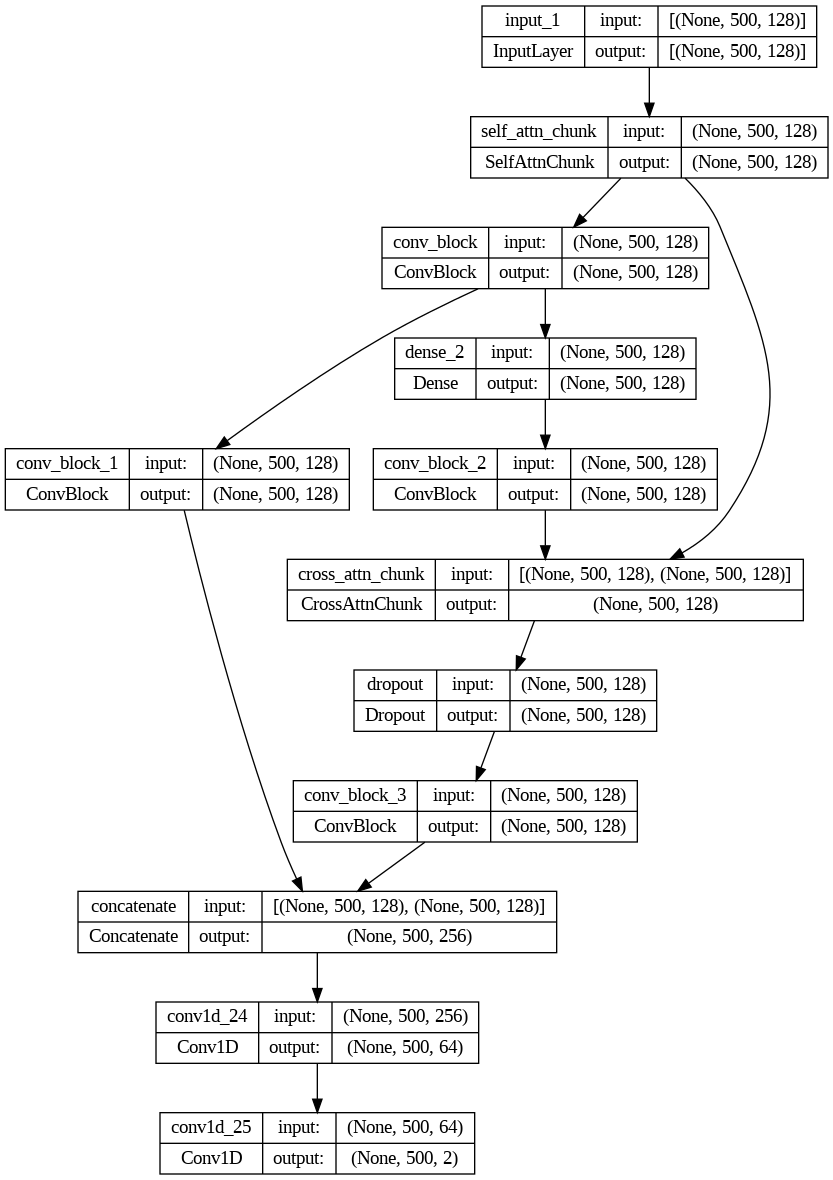

In [22]:
temp_model = chunk_module(128, 1,500, 3,300,)
temp_model.build((2, 500, 3))

tf.keras.utils.plot_model(temp_model, show_shapes=True,
                                        expand_nested=True)

In [23]:
num_classes = len(np.unique(Y_train))
num_classes

26

## Model

In [24]:
class SplitTransformer(keras.Model):
  def __init__(
      self,
      embed_dim,
      num_heads,
      # latent_dim = 512,
      chunk_size=chunk_size,
      activation=tf.nn.gelu,
      dropout_rate=0.25,
      attn_block_repeats=1,
      attention_range=attention_range):
    super(SplitTransformer, self).__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.chunk_size = chunk_size
    self.activation = activation
    self.dropout_rate = dropout_rate
    self.attn_block_repeats = attn_block_repeats
    self.attention_range = attention_range

  def build(self, input_shape):
    self.chunk_starts = list(range(0, input_shape[1], self.chunk_size))
    self.chunk_ends = []
    for cs in self.chunk_starts:
      self.chunk_ends.append(min(cs+self.chunk_size, input_shape[1]))
    self.mask_starts = [max(0, cs-self.attention_range) for cs in self.chunk_starts]
    self.mask_ends = [min(ce+self.attention_range, input_shape[1]) for ce in self.chunk_ends]
    self.chunkers = [chunk_module(self.embed_dim, self.num_heads,
                                  self.mask_ends[i] - self.mask_starts[i],
                                  inChannel, self.attention_range,
                                  start_offset=cs - self.mask_starts[i],
                                  end_offset=self.mask_ends[i]-self.chunk_ends[i],
                                  attn_block_repeats=1, include_embedding=True) for i,cs in enumerate(self.chunk_starts)]

    self.concat_layer = layers.Concatenate(axis=-2)
    self.embedding = GenoEmbeddings(self.embed_dim)
    super(SplitTransformer, self).build(input_shape)


  def call(self, inputs):
    x = self.embedding(inputs)
    chunks = [self.chunkers[i](x[:, self.mask_starts[i]:self.mask_ends[i]]) for i, chunker in enumerate(self.chunkers)]
    y = self.concat_layer(chunks)
    return y


In [25]:
class MyCustomLoss(tf.keras.losses.Loss):

  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
    cat_loss = loss_obj(y_true, y_pred)

    loss_obj = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.SUM)
    kl_loss = loss_obj(y_true, y_pred)

    return cat_loss + kl_loss

In [26]:
METRIC = "val_loss"

def create_callbacks(kfold=0, metric = METRIC):

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='auto',
        factor=0.2,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='auto',
        patience= 20,
        verbose=1,
        restore_best_weights=True
    )

    callbacks = [
                 reducelr,
                 earlystop]

    return callbacks

In [27]:
def create_model():
  model =  SplitTransformer(embed_dim=256,
      num_heads=40,
      attn_block_repeats=1,
      chunk_size=X.shape[1],
      activation="gelu",
      attention_range=0)
  optimizer = tfa.optimizers.LAMB(learning_rate=learning_rate)
  model.compile(optimizer, loss=MyCustomLoss(), metrics=tf.keras.metrics.CategoricalAccuracy())
  return model


In [28]:
temp_model = create_model()
temp_model.build((1, X.shape[1], inChannel))
temp_model.summary()

Model: "split_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 573, 2)            23912834  
                                                                 
 concatenate_2 (Concatenate)  multiple                 0         
                                                                 
 geno_embeddings (GenoEmbedd  multiple                 147456    
 ings)                                                           
                                                                 
Total params: 24,060,290
Trainable params: 24,056,194
Non-trainable params: 4,096
_________________________________________________________________


In [29]:
def get_three_sets(x, y, random_state, population_label, missing_perc):
  np.random.seed(seed=random_state)
  _x = x[x.index.isin(y.index)].to_numpy()
  _y = y.to_numpy()
  x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.20,
                                        random_state=random_state,
                                        shuffle=True,
                                        stratify=_y,)
  train_indices, test_indices = train_test_split(y.index, test_size=0.20,
                                        random_state=random_state,
                                        shuffle=True,
                                        stratify=_y,)
  return x_train, y_train, (x_test, y_test), test_indices


In [30]:
np.unique(Y_train.values)

array(['ACB', 'ASW', 'BEB', 'CDX', 'CEU', 'CHB', 'CHS', 'CLM', 'ESN',
       'FIN', 'GBR', 'GIH', 'GWD', 'IBS', 'ITU', 'JPT', 'KHV', 'LWK',
       'MSL', 'MXL', 'PEL', 'PJL', 'PUR', 'STU', 'TSI', 'YRI'],
      dtype=object)

## Training

In [31]:
# A TPU V3-8 has 8 computing cores, the global batch size will be 1/16 x 8 = 8/128
BATCH_SIZE_BASE = 2
# Training configuration
BATCH_SIZE = BATCH_SIZE_BASE * N_REPLICAS if TPU else 5
BATCH_SIZE

16

In [32]:
save_dir = "[save_dir]/"

if not os.path.exists(save_dir):
  # shutil.rmtree(save_dir)
  os.makedirs(save_dir)

In [33]:
# With constraint
missing_perc = 0.1
N_SPLITS=3
NUM_EPOCHS = 1000
accuracies = []
results = None
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
_y = Y_train.to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1

  print(f"Training using fold {fold}")

  x_train, y_train, test_dataset, test_indices = _x[train_index], _y[train_index], (_x[test_index], _y[test_index]),Y_train.index[test_index]
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10,
                                      random_state=fold,
                                      shuffle=True)

  steps_per_epoch = 2*x_train.shape[0]//BATCH_SIZE
  validation_steps = 2*x_valid.shape[0]//BATCH_SIZE
  train_dataset = get_dataset(x_train, 0, feature_size, 0, 0, BATCH_SIZE)
  valid_dataset = get_dataset(x_valid, 0, feature_size, 0, 0, BATCH_SIZE, training=False)

  K.clear_session()
  callbacks = create_callbacks()
  with strategy.scope():
    model = create_model()
    history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS,
            validation_data=valid_dataset,
            validation_steps=validation_steps,
            callbacks=callbacks, verbose=0)
  for missing_perc in [
                         0.05,
                         0.1,
                         0.2
                         ]:
    save_name = save_dir + f"preds_mixed_mr_{missing_perc}_fold_{fold}_probs"
    avg_accuracy = []
    preds = []
    true_labels = []

    # to_save_array = np.zeros((test_dataset[0].shape[0], test_dataset[0].shape[1]), dtype=object)
    test_X_missing = np.empty((test_dataset[0].shape[0] * 2, test_dataset[0].shape[1]), dtype=test_dataset[0].dtype)
    map_values_1_vec = np.vectorize(map_values_1)
    map_values_2_vec = np.vectorize(map_values_2)
    test_X_missing[0::2] = map_values_1_vec(test_dataset[0])
    test_X_missing[1::2] = map_values_2_vec(test_dataset[0])
    test_X_missing = to_categorical(test_X_missing, 3)


    for i in tqdm(range(test_dataset[0].shape[0])):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      test_X_missing[i*2:i*2+2, missing_index, :] = [0, 0, 1]
      # mMask = np.tile(attention_mask, (1, 1, 1))
      # predict
    predict_onehots = model.predict(test_X_missing, verbose=0)
    to_save_array = np.copy(predict_onehots)
    for i in tqdm(range(test_dataset[0].shape[0])):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      predict_missing_onehot = predict_onehots[i*2:(i+1)*2, missing_index, :]
      # predict label
      predict_missing = np.argmax(predict_missing_onehot, axis=2)
      predict_missing_final = np.zeros((1, predict_missing.shape[1]))
      for j in range(predict_missing.shape[1]):
        if predict_missing[:, j].tolist() == [0, 0]:
          predict_missing_final[:, j] = 0
        elif predict_missing[:, j].tolist() == [0, 1]:
          predict_missing_final[:, j] = 1
        elif predict_missing[:, j].tolist() == [1, 0]:
          predict_missing_final[:, j] = 2
        elif predict_missing[:, j].tolist() == [1, 1]:
          predict_missing_final[:, j] = 3
        else:
          predict_missing_final[:, j] = 4
      preds.extend(predict_missing_final.ravel().tolist())

      # predict_haplotypes = np.argmax(predict_onehots[i*2:(i+1)*2], axis=2)
      # for j in range(predict_onehots.shape[1]):
      #   if predict_haplotypes[:, j].tolist() == [0,0]:
      #     to_save_array[i, j] = '0|0'
      #   elif predict_haplotypes[:, j].tolist() == [0,1]:
      #     to_save_array[i, j] = '0|1'
      #   elif predict_haplotypes[:, j].tolist() == [1,0]:
      #     to_save_array[i, j] = '1|0'
      #   elif predict_haplotypes[:, j].tolist() == [1, 1]:
      #     to_save_array[i, j] = '1|1'
      #   else:
      #     to_save_array[i, j] = '.|.'
      # real label
      label_missing_onehot = test_dataset[0][i:i + 1, missing_index]
      # label_missing = np.argmax(label_missing_onehot, axis=2)
      label_missing = test_dataset[0][i:i + 1, missing_index]
      true_labels.extend(label_missing.ravel().tolist())
      # accuracy
      correct_prediction = np.equal(predict_missing_final, label_missing)
      accuracy = np.mean(correct_prediction)
      # print('{}/{}, accuracy: {:.4f}'.format(
      #     i, test_X_missing.shape[0], accuracy))

      avg_accuracy.append(accuracy)

    # df = pd.DataFrame(to_save_array, columns= headers[:], index = Y_train.index[test_index])
    # df.to_csv(save_name)
    np.save(save_name, to_save_array)
    print('The average imputation accuracy' \
          'on test data with {} missing genotypes is {:.4f}: '
        .format(missing_perc, np.mean(avg_accuracy)))
    cnf_matrix = confusion_matrix(true_labels, preds)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print(f"Sensitivity: {np.mean(TPR)}")
    print(f"Specificity: {np.mean(TNR)}")
    print(f"F1-score macro: {f1_score(true_labels, preds, average='macro')}")
    print(f"F1-score micro: {f1_score(true_labels, preds, average='micro')}")
    accuracies.append(np.mean(avg_accuracy))
  print(f"=====================================")



Training using fold 1
Restoring model weights from the end of the best epoch: 17.
Epoch 37: early stopping


100%|██████████| 835/835 [00:03<00:00, 263.06it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9679: 
Sensitivity: 0.42131999342632154
Specificity: 0.8051703245925513
F1-score macro: 0.4736603474248404
F1-score micro: 0.9679213002566296


100%|██████████| 835/835 [00:04<00:00, 189.64it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9676: 
Sensitivity: 0.40532147219617287
Specificity: 0.8010305927563899
F1-score macro: 0.46117498520043887
F1-score micro: 0.9676226494379662


100%|██████████| 835/835 [00:03<00:00, 271.57it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9631: 
Sensitivity: 0.4135369834008785
Specificity: 0.8120893672647446
F1-score macro: 0.46654339012810336
F1-score micro: 0.9630738522954092
Training using fold 2
Restoring model weights from the end of the best epoch: 20.
Epoch 40: early stopping


100%|██████████| 835/835 [00:04<00:00, 176.02it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9696: 
Sensitivity: 0.4162834614600355
Specificity: 0.812900524583385
F1-score macro: 0.4768896367708888
F1-score micro: 0.9696321642429427


100%|██████████| 835/835 [00:03<00:00, 268.55it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9704: 
Sensitivity: 0.41733724631822455
Specificity: 0.8103289083770829
F1-score macro: 0.4786033770637332
F1-score micro: 0.9703540287845361


100%|██████████| 835/835 [00:03<00:00, 268.31it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9649: 
Sensitivity: 0.42775313201204257
Specificity: 0.8191305458006676
F1-score macro: 0.48089408964875346
F1-score micro: 0.9648912700913962
Training using fold 3
Restoring model weights from the end of the best epoch: 43.
Epoch 63: early stopping


100%|██████████| 834/834 [00:03<00:00, 251.13it/s]


The average imputation accuracyon test data with 0.05 missing genotypes is 0.9699: 
Sensitivity: 0.4292107032654298
Specificity: 0.80836039551409
F1-score macro: 0.48718791656118104
F1-score micro: 0.9699383350462487


100%|██████████| 834/834 [00:04<00:00, 175.73it/s]


The average imputation accuracyon test data with 0.1 missing genotypes is 0.9697: 
Sensitivity: 0.414368521253193
Specificity: 0.805214970103482
F1-score macro: 0.4738646068066312
F1-score micro: 0.9696663721654255


100%|██████████| 834/834 [00:03<00:00, 266.05it/s]


The average imputation accuracyon test data with 0.2 missing genotypes is 0.9646: 
Sensitivity: 0.4198661461896881
Specificity: 0.8172960054814388
F1-score macro: 0.47629613290734696
F1-score micro: 0.9646493331650469


In [34]:
from google.colab import runtime
runtime.unassign()